

## Problem statement : Convert an MNIST classifier NN into digit shapes generation. What are the chances of generating a digit that wasn't used for training.

## **Steps:**

- Imported the PyTorch library to build models, along with torchvision for handling datasets and matplotlib for visualizing results.

- The computation was set to a GPU by default, falling back to CPU if this was not available.

- Instantiated the MNIST dataset of handwritten digits, ranging from 0 through 9, preprocessed their images into tensors, and divided the data into training and testing datasets using DataLoaders for batching.

- Defined a VAE that included an encoder to compress input images into a small latent space, applied a reparameterization trick to add randomness, and used a decoder to reconstruct images from this latent space.

- The VAE was trained by minimizing the reconstruction loss to accurately recreate images.

- Constructed a CNN classifier with convolutional layers to extract features and fully connected layers to predict the digit classes ranging from 0 to 9.

- Trained the classifier-CNN through minimizing cross-entropy loss over several epochs.

- Specific digits were generated between 1 and 9. This was done by initializing the random latent vector, optimizing with the classifier's feedback to maximize the confidence for the target digit, and then reconstructing the image using the VAE decoder.

- Tried generating images for the non-existent class, say digit 11. Since the classifier hasn't seen this class at all, the generated output was random.

- Visualized generated images for digits 1–9 and created funny images for non-existent classes.

In [ ]:
#importing necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)#creating loaders for batch processing
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder- compresses the image
        self.fc1 = nn.Linear(28*28, 400) #400 features
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_var = nn.Linear(400, latent_dim)

        # Decoder- uses compressed image
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = F.relu(self.fc1(x))# passes the input to incoder
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):#adds randomness
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):#reconstructs the image
        h = F.relu(self.fc3(z))
        x_recon = torch.sigmoid(self.fc4(h))
        return x_recon

    def forward(self, x):# forward pass
        mu, log_var = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

In [ ]:
def vae_loss(x, x_recon, mu, log_var):
  # Reconstruction loss
  recon_loss = F.binary_cross_entropy(x_recon, x.view(-1, 28*28), reduction='sum')
  kld = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp())
  return (recon_loss + kld) / x.size(0)

In [ ]:
vae = VAE(latent_dim=20).to(device)
vae_optimizer = optim.Adam(vae.parameters(), lr=0.001)

vae_epochs = 5
vae.train()
for epoch in range(vae_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        vae_optimizer.zero_grad()
        x_recon, mu, log_var = vae(images)
        loss = vae_loss(images, x_recon, mu, log_var)
        loss.backward()
        vae_optimizer.step()#update weights
        total_loss += loss.item()
    print(f"VAE Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

VAE Epoch 1, Loss: 147.5015
VAE Epoch 2, Loss: 115.6570
VAE Epoch 3, Loss: 111.1312
VAE Epoch 4, Loss: 109.1668
VAE Epoch 5, Loss: 107.9674


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)# convolutional layers for feature extraction
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128 ) #for classification
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))# forward pass through CNN
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

clf_epochs = 5
model.train()# training the classifier
for epoch in range(clf_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Classifier Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Classifier Epoch 1, Loss: 0.2113
Classifier Epoch 2, Loss: 0.0590
Classifier Epoch 3, Loss: 0.0399
Classifier Epoch 4, Loss: 0.0310
Classifier Epoch 5, Loss: 0.0240


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        out = model(images)
        _, pred = torch.max(out, 1)
        total += labels.size(0)
correct += (pred == labels).sum().item()
print(f"Classifier Accuracy: {100*correct/total:.2f}%")

Classifier Accuracy: 99.02%


Step 0, Loss: 0.0003, Prob: 0.9997
Step 500, Loss: -0.0000, Prob: 1.0000
Step 1000, Loss: -0.0000, Prob: 1.0000
Step 1500, Loss: -0.0000, Prob: 1.0000
Step 2000, Loss: -0.0000, Prob: 1.0000
Step 2500, Loss: -0.0000, Prob: 1.0000


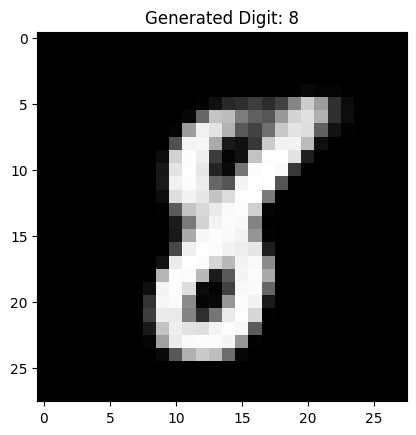

In [ ]:

target_digit = 8
z = torch.randn((1, vae.latent_dim), requires_grad=True, device=device)
gen_optimizer = optim.Adam([z], lr=0.1)

model.eval()
vae.eval()

for step in range(3000):
    gen_optimizer.zero_grad()
    x_gen = vae.decode(z) # shape: (1, 28*28)
    x_gen_img = x_gen.view(1,1,28,28)

    out = model(x_gen_img)
    target_prob = F.softmax(out, dim=1)[0, target_digit]
    loss = -torch.log(target_prob + 1e-10)
    loss.backward()
    gen_optimizer.step()

if step % 500 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}, Prob: {target_prob.item():.4f}")

x_final = vae.decode(z).view(28,28).detach().cpu().numpy()
plt.title(f"Generated Digit: {target_digit}")
plt.imshow(x_final, cmap='gray')
plt.show()

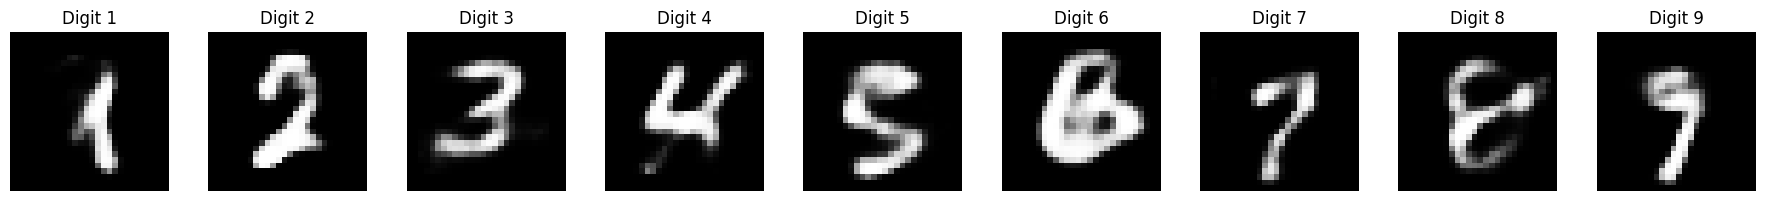

In [ ]:

digits_to_generate = [i for i in range(1, 10)]  # digits from 1 to 9
fig, axs = plt.subplots(1, 9, figsize=(18, 2))

for idx, target_digit in enumerate(digits_to_generate):

    z = torch.randn((1, vae.latent_dim), requires_grad=True, device=device)
    gen_optimizer = optim.Adam([z], lr=0.1)

    steps = 1000
    for step in range(steps):
        gen_optimizer.zero_grad()
        x_gen = vae.decode(z)  # shape: (1, 28*28)
        x_gen_img = x_gen.view(1,1,28,28)

        out = model(x_gen_img)
        target_prob = F.softmax(out, dim=1)[0, target_digit]
        loss = -torch.log(target_prob + 1e-10)
        loss.backward()
        gen_optimizer.step()

    # generate final image
    x_final = vae.decode(z).reshape(28,28).detach().cpu().numpy()
    axs[idx].imshow(x_final, cmap='gray')
    axs[idx].set_title(f"Digit {target_digit}")
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

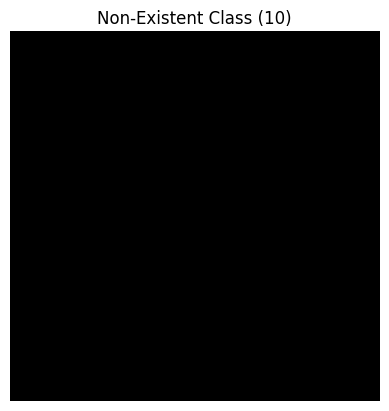

In [ ]:

def generate_digit(target_class, steps=500, lr=0.1):
    image = torch.randn(1, 1, 28, 28, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([image], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        out = model(image)
        if target_class < 0 or target_class > 9:
        # Non-existent class
            loss = torch.mean(image**2)
        else:
            target_prob = F.softmax(out, dim=1)[0, target_class]
            loss = -torch.log(target_prob + 1e-10)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
             image.clamp_(0, 1)

    return image.detach().cpu().numpy().squeeze()


non_existent_class = 10
nonsense_image = generate_digit(non_existent_class)

plt.figure()
plt.title("Non-Existent Class (10)")
plt.imshow(nonsense_image, cmap='gray')
plt.axis('off')
plt.show()
